In [1]:
# Copyright (c) TorchGeo Contributors. All rights reserved.
# Licensed under the MIT License.

# Introduction to PyTorch

_Written by: Adam J. Stewart_

In this tutorial, we introduce the basics of deep learning with PyTorch. Understanding deep learning terminology and the training and evaluation pipeline in PyTorch is essential to using TorchGeo.

## Setup

First, we install TorchGeo and all of its dependencies, including PyTorch.

In [2]:
%pip install torchgeo

Note: you may need to restart the kernel to use updated packages.


## Imports

Next, we import PyTorch, TorchGeo, and any other libraries we need. We also manually set the random seed to ensure the reproducibility of our experiments.

In [3]:
import os
import tempfile

import kornia.augmentation as K
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchgeo.datasets import EuroSAT100
from torchgeo.models import ResNet18_Weights, resnet18

torch.manual_seed(0)

## Definitions

If this is your first introduction to deep learning (DL), a natural question might be "what _is_ deep learning?". You may also be curious how it relates to other similar buzz words, including artificial intelligence (AI) and machine learning (ML). We can define these terms as follows:

* AI: when machines exhibit human intelligence
* ML: when machines learn from example
* DL: when machines learn using neural networks

In this definition, DL is a subset of ML, and ML is a subset of AI. Some common examples of models and applications of these include:

* AI: Minimax, A*, Deep Blue, video game AI
* ML: OLS, SVM, $k$-means, spam filtering
* DL: MLP, CNN, ChatGPT, self-driving cars

In this tutorial, we will specifically focus on deep learning, but many of the same concepts are shared with machine learning.

## Datasets

In order to learn by example, we first need examples. In machine learning, we construct datasets of the form:

$$D = \left\{\left(x^{(i)}, y^{(i)}\right)\right\}_{i=1}^N$$

Written in English, dataset $D$ is composed of $N$ pairs of inputs $x$ and expected outputs $y$. $x$ and $y$ can be tabular data, images, text, or any other object that can be represented mathematically.

![EuroSAT](https://github.com/phelber/EuroSAT/blob/master/eurosat-overview.png?raw=true)

In this tutorial (and many later tutorials), we will use EuroSAT100, a toy dataset composed of 100 images from the [EuroSAT](https://github.com/phelber/EuroSAT) dataset. EuroSAT is a popular image classification dataset with multispectral images from the Sentinel-2 satellites. Each image is classified into one of ten categories or "classes":

0. Annual Crop
1. Forest
2. Herbaceous Vegetation
3. Highway
4. Industrial Buildings
5. Pasture
6. Permanent Crop
7. Residential Buildings
8. River
9. Sea & Lake

We can load this dataset and visualize the RGB bands of some example $(x, y)$ pairs like so:

100%|██████████| 1.15k/1.15k [00:00<00:00, 443kB/s]
100%|██████████| 7.72M/7.72M [00:00<00:00, 20.3MB/s]


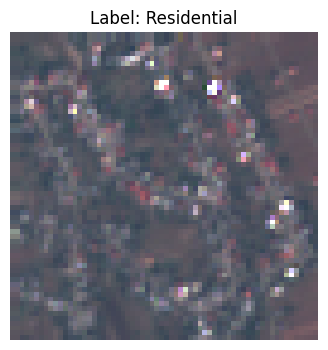

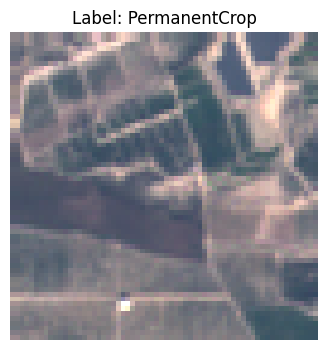

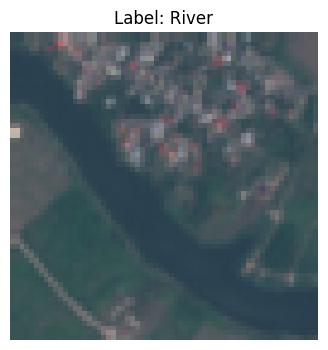

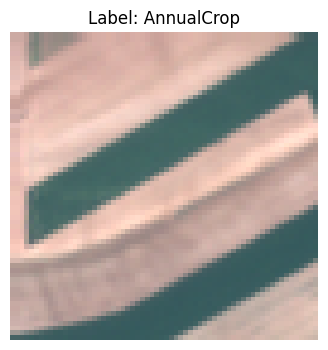

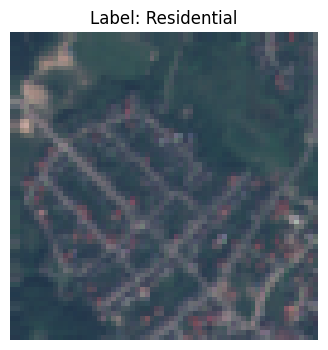

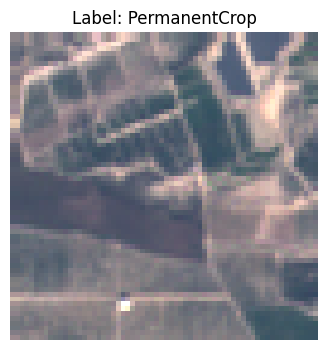

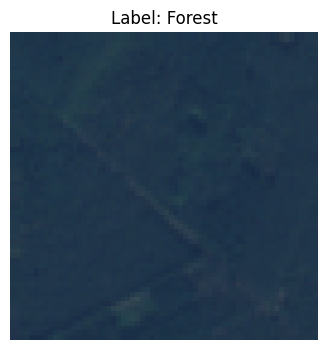

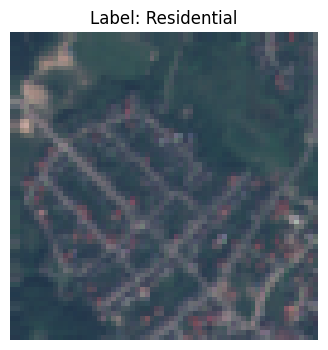

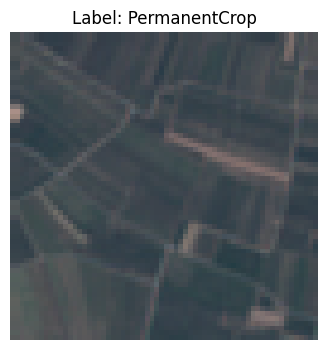

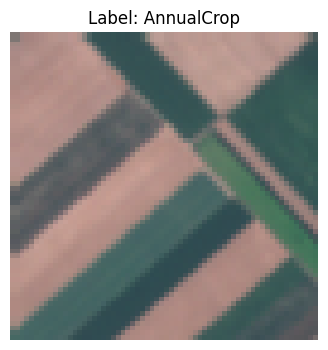

In [4]:
root = os.path.join(tempfile.gettempdir(), 'pytorch')
dataset = EuroSAT100(root, download=True)

for i in torch.randint(len(dataset), (10,)):
    sample = dataset[i]
    dataset.plot(sample)

In machine learning, we not only want to train a model, but also evaluate its performance on unseen data. Oftentimes, our dataset is split into three separate subsets:

* train: for training the model *parameters*
* val: for validating the model *hyperparameters*
* test: for testing the model *performance*

Parameters are the actual model weights, while hyperparameters are things like model width or learning rate that are chosen by the user. We can initialize datasets for all three splits like so:

In [5]:
train_dataset = EuroSAT100(root, split='train', download=True)
val_dataset = EuroSAT100(root, split='val', download=True)
test_dataset = EuroSAT100(root, split='test', download=True)

100%|██████████| 382/382 [00:00<00:00, 84.1kB/s]


## Data Loaders

While our dataset objects know how to load a single $(x, y)$ pair, machine learning often operates on what are called *mini-batches* of data. We can pass our above datasets to a PyTorch DataLoader object to construct these mini-batches:

In [6]:
batch_size = 10

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

## Transforms

There are two categories of transforms a user may want to apply to their data:

* Preprocessing: required to make data "ML-ready"
* Data augmentation: designed to artificially inflate the size of the dataset

Preprocessing transforms such as normalization and one-hot encodings are applied to both training and evaluation data. Data augmentation transforms such as random flip and rotation are typically only performed during training. Below, we initialize transforms for both using the [Kornia](https://kornia.readthedocs.io/en/latest/augmentation.html) library.

In [7]:
preprocess = K.Normalize(0, 10000)
augment = K.ImageSequential(K.RandomHorizontalFlip(), K.RandomVerticalFlip())

## Model

Our goal is to learn some function $f$ that can map between input $x$ and expected output $y$. Mathematically, this can be expressed as:

$$x \overset{f}{\mapsto} y, \quad y = f(x)$$

Since our $x$ in this case is an image, we choose to use ResNet-18, a popular *convolutional neural network* (CNN). We also initialize our model with weights that have been pre-trained on Sentinel-2 imagery so we don't have to start from scratch. This process is known as *transfer learning*.

In [8]:
model = resnet18(ResNet18_Weights.SENTINEL2_ALL_MOCO)

Downloading: "https://hf.co/torchgeo/resnet18_sentinel2_all_moco/resolve/5b8cddc9a14f3844350b7f40b85bcd32aed75918/resnet18_sentinel2_all_moco-59bfdff9.pth" to /Users/julianwebber/.cache/torch/hub/checkpoints/resnet18_sentinel2_all_moco-59bfdff9.pth


100%|██████████| 42.8M/42.8M [00:01<00:00, 37.5MB/s]


## Loss Function

If $y$ is our expected output (also called "ground truth") and $\hat{y}$ is our predicted output, our goal is to minimize the difference between $y$ and $\hat{y}$. This difference is referred to as *error* or *loss*, and the loss function tells us how big of a mistake we made. For regression tasks, a simple mean squared error is sufficient:

$$L(y, \hat{y}) = \left(y - \hat{y}\right)^2$$

For classification tasks, such as EuroSAT, we instead use a negative log-likelihood:

$$L_c(y, \hat{y}) = - \sum_{c=1}^C \mathbb{1}_{y=\hat{y}}\log{p_c}$$

where $\mathbb{1}$ is the indicator function and $p_c$ is the probability with which the model predicts class $c$. By normalizing this over the log probability of all classes, we get the cross-entropy loss.

In [9]:
loss_fn = nn.CrossEntropyLoss()

## Optimizer

In order to minimize our loss, we compute the gradient of the loss function with respect to model parameters $\theta$. We then take a small step $\alpha$ (also called the *learning rate*) in the direction of the negative gradient to update our model parameters in a process called *backpropagation*:

$$\theta \leftarrow \theta - \alpha \nabla_\theta L(y, \hat{y})$$

When done one image or one mini-batch at a time, this is known as *stochastic gradient descent* (SGD).

In [10]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)

## Device

If you peak into the internals of deep learning models, you'll notice that most of it is actually linear algebra. This linear algebra is extremely easy to parallelize, and therefore can run very quickly on a GPU. We now transfer our model and all data to the GPU (if one is available):

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

## Training

We finally have all the basic components we need to train our ResNet-18 model on the EuroSAT100 dataset. During training, we set the model to train mode, then iterate over all mini-batches in the dataset. During the forward pass, we ask the model $f$ to predict $\hat{y}$ given $x$. We then calculate the loss accrued by these predictions. During the backward pass, we backpropagate our gradients to update all model weights.

In [12]:
def train(dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        x = batch['image'].to(device)
        y = batch['label'].to(device)
        x = preprocess(x)
        x = augment(x)

        # Forward pass
        y_hat = model(x)
        loss = loss_fn(y_hat, y)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    print(f'Loss: {total_loss:.2f}')

## Evaluation

Once the model is trained, we need to evaluate its performance on unseen data. To do this, we set the model to evaluation mode, then iterate over all mini-batches in the dataset. Note that we also disable the computation of gradients, since we do not need to backpropagate them. Finally, we compute the number of correctly classified images.

In [13]:
def evaluate(dataloader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch in dataloader:
            x = batch['image'].to(device)
            y = batch['label'].to(device)
            x = preprocess(x)

            # Forward pass
            y_hat = model(x)
            correct += (y_hat.argmax(1) == y).type(torch.float).sum().item()

    correct /= len(dataloader.dataset)
    print(f'Accuracy: {correct:.0%}')

## Putting It All Together

In machine learning, we typically iterate over our datasets multiple times. Each full pass through the dataset is called an *epoch*. The following hyperparameter controls the number of epochs for which we train our model, and can be modified to train the model for longer:

In [14]:
epochs = 100

During each epoch, we train the model on our training dataset, then evaluate its performance on the validation dataset. The goal is for training loss to decrease and validation accuracy to increase, although you should expect noise in the training process. Generally, you want to train the model until the validation accuracy starts to plateau or even decrease.

In [15]:
for epoch in range(epochs):
    print(f'Epoch: {epoch}')
    train(train_dataloader)
    evaluate(val_dataloader)

Epoch: 0
Loss: 41.40
Accuracy: 0%
Epoch: 1
Loss: 41.25
Accuracy: 0%
Epoch: 2
Loss: 41.11
Accuracy: 0%
Epoch: 3
Loss: 40.96
Accuracy: 0%
Epoch: 4
Loss: 40.84
Accuracy: 0%
Epoch: 5
Loss: 40.76
Accuracy: 5%
Epoch: 6
Loss: 40.53
Accuracy: 10%
Epoch: 7
Loss: 40.43
Accuracy: 20%
Epoch: 8
Loss: 40.23
Accuracy: 25%
Epoch: 9
Loss: 40.11
Accuracy: 25%
Epoch: 10
Loss: 39.84
Accuracy: 30%
Epoch: 11
Loss: 39.68
Accuracy: 30%
Epoch: 12
Loss: 39.38
Accuracy: 30%
Epoch: 13
Loss: 39.13
Accuracy: 30%
Epoch: 14
Loss: 39.07
Accuracy: 35%
Epoch: 15
Loss: 38.65
Accuracy: 35%
Epoch: 16
Loss: 38.50
Accuracy: 35%
Epoch: 17
Loss: 38.18
Accuracy: 35%
Epoch: 18
Loss: 37.82
Accuracy: 35%
Epoch: 19
Loss: 37.75
Accuracy: 35%
Epoch: 20
Loss: 37.20
Accuracy: 35%
Epoch: 21
Loss: 36.68
Accuracy: 35%
Epoch: 22
Loss: 36.37
Accuracy: 35%
Epoch: 23
Loss: 36.08
Accuracy: 40%
Epoch: 24
Loss: 35.70
Accuracy: 45%
Epoch: 25
Loss: 35.52
Accuracy: 55%
Epoch: 26
Loss: 33.83
Accuracy: 50%
Epoch: 27
Loss: 33.68
Accuracy: 55%
Epoch: 2

Finally, we evaluate our performance on the test dataset. Note that we are only training our model on a toy dataset consisting of 100 images. If we instead trained on the full dataset (replace `EuroSAT100` with `EuroSAT` in the above code), we would likely get much higher performance.

In [16]:
evaluate(test_dataloader)

Accuracy: 90%


## Additional Reading

If you are new to machine learning and overwhelmed by all of the above terminology, or would like to gain a better understanding of some of the math that goes into machine learning, I would highly recommend a formal machine learning or deep learning course. The following official PyTorch tutorials are also worth exploring:

* [PyTorch: Learn the Basics](https://pytorch.org/tutorials/beginner/basics/intro.html)
* [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Transfer Learning for Computer Vision](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)